In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%autosave 0

Autosave disabled


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Initial data sets
listing=pd.read_csv("listings_2.csv")
review = pd.read_csv('reviews_2.csv')

# Data Clean-Up

##      1. Review Data

In [5]:
#sentiment analysis
review1 = review.merge(listing[['id','neighbourhood_group_cleansed', 'neighbourhood_cleansed','property_type']] ,\
                       left_on='listing_id', right_on='id')
rm = review1[review1.neighbourhood_group_cleansed=='Manhattan']

In [6]:
rm.drop(['id_x','date','id_y','reviewer_id','reviewer_name'],axis=1,inplace=True)

In [7]:
rm.comments.fillna(value='',inplace=True)
review1.comments.fillna(value='',inplace=True)
rm.isna().any()

listing_id                      False
comments                        False
neighbourhood_group_cleansed    False
neighbourhood_cleansed          False
property_type                   False
dtype: bool

## 2. Listing Data

In [8]:
#price prediction 
listing_nyc=listing[listing.neighbourhood_group_cleansed=="Manhattan"]

###  Price

In [9]:
listing_nyc.price.dtypes

dtype('O')

In [10]:
listing_nyc["price"]=listing_nyc["price"].str.replace("[\$\.\,]","").astype(int)
listing_nyc["price"]=listing_nyc["price"]/100.00

### NaN Checking

In [11]:
listing_nyc.isna().sum()[listing_nyc.isna().sum()>1]

name                               9
description                      446
neighborhood_overview           8092
host_name                          4
host_since                         4
host_location                     62
host_about                      8271
host_response_time             10442
host_response_rate             10442
host_acceptance_rate            7730
host_is_superhost                  4
host_thumbnail_url                 4
host_picture_url                   4
host_neighbourhood              4064
host_listings_count                4
host_total_listings_count          4
host_has_profile_pic               4
host_identity_verified             4
neighbourhood                   8092
bathrooms                      19741
bathrooms_text                    51
bedrooms                        2718
beds                             203
minimum_minimum_nights             6
maximum_minimum_nights             6
minimum_maximum_nights             6
maximum_maximum_nights             6
m

### Host Related Variables

In [12]:
#superhost
listing_nyc["host_is_superhost"].fillna("f",inplace=True)
listing_nyc['host_is_superhost1'] = listing_nyc['host_is_superhost']
listing_nyc["host_is_superhost1"].replace(["t", "f"], [1, 0], inplace = True)

In [13]:
# Convert the variables of superhost indicator to better presenting variables
listing_nyc['host_is_superhost'].replace('t','SuperHost',inplace = True) 
listing_nyc['host_is_superhost'].replace('f','RegularHost',inplace =True)

In [14]:
# Convert host response rate to numerical variables
listing_nyc["host_response_rate"] = listing_nyc["host_response_rate"].str.replace("%", "")
listing_nyc["host_response_rate"] = listing_nyc["host_response_rate"].astype(float) / 100
listing_nyc["host_response_rate"].fillna(0,inplace=True)

In [15]:
# Convert host acceptance rate to numerical variables
listing_nyc["host_acceptance_rate"] = listing_nyc["host_acceptance_rate"].str.replace("%", "")
listing_nyc["host_acceptance_rate"] = listing_nyc["host_acceptance_rate"].astype(float) / 100
listing_nyc["host_acceptance_rate"].fillna(0,inplace=True)

In [16]:
listing_nyc["host_response_time"].fillna("No responsing",inplace=True)
listing_nyc["host_has_profile_pic"].fillna("Missing",inplace=True)
listing_nyc["host_identity_verified"].fillna("Missing",inplace=True)

In [17]:
listing_nyc.has_availability.replace(["t", "f"], [1, 0], inplace = True)
listing_nyc.instant_bookable.replace(["t", "f"], [1, 0], inplace = True)

### Bathroom Type and Number

In [18]:
listing_nyc["bathrooms_text"]=listing_nyc.bathrooms_text.str.lower()

In [19]:
listing_nyc.bathrooms_text.unique()

array(['1 bath', '1 shared bath', '1 private bath', nan,
       'shared half-bath', '2 baths', '1.5 baths', 'half-bath',
       '0 shared baths', '1.5 shared baths', '2.5 baths', '3 baths',
       'private half-bath', '0 baths', '2 shared baths',
       '2.5 shared baths', '5 baths', '3.5 baths', '4 baths', '5.5 baths',
       '8 shared baths', '4.5 baths', '3 shared baths',
       '3.5 shared baths', '4 shared baths', '6.5 baths',
       '4.5 shared baths', '7.5 baths', '6 baths', '8 baths'],
      dtype=object)

In [20]:
listing_nyc["bathrooms_text"].replace(to_replace=["half-bath","private half-bath"],value="0.5 bath",inplace=True)

- Creat new column with bath_shared (binary)

In [21]:
listing_nyc["bath_shared"]=listing_nyc.bathrooms_text.str.contains("shared")*1.0

In [22]:
listing_nyc[listing_nyc["bath_shared"].isna()  ]["room_type"].unique()

array(['Private room', 'Shared room', 'Entire home/apt', 'Hotel room'],
      dtype=object)

- For Nan in bath_share, we check the room type to see whether it is share room or not.

In [23]:
listing_nyc.loc[(listing_nyc["bath_shared"].isna())&(listing_nyc["room_type"]=='Shared room'),"bath_shared"]=1.0
listing_nyc.loc[(listing_nyc["bath_shared"].isna()),"bath_shared"]=0.0

- Create column bath_count and extract the number of bathrooms from bathrooms_text.

In [24]:
listing_nyc["bath_count"]=listing_nyc.bathrooms_text.str.extract('(\d+\.?\d*)', expand=False).astype(float)
listing_nyc["bath_count"].fillna(1,inplace=True)

In [25]:
listing_nyc.drop(columns="bathrooms_text",inplace=True)

### The Rest of Variables

In [26]:
listing_nyc["bedrooms"].fillna(1,inplace=True)
listing_nyc["beds"].fillna(1,inplace=True)

In [27]:
listing_nyc["host_listings_count"].fillna(1,inplace=True)
listing_nyc["host_total_listings_count"].fillna(1,inplace=True)

In [28]:
#choose 40 percentile of the score for Nan
rev_rating=listing_nyc.review_scores_rating.quantile(0.4)
listing_nyc.review_scores_rating.fillna(rev_rating,inplace=True)

rev_accuracy=listing_nyc.review_scores_accuracy.quantile(0.4)
listing_nyc.review_scores_accuracy.fillna(rev_accuracy,inplace=True)

rev_clean=listing_nyc.review_scores_cleanliness.quantile(0.4)
listing_nyc.review_scores_cleanliness.fillna(rev_clean,inplace=True)

rev_checkin=listing_nyc.review_scores_checkin.quantile(0.4)
listing_nyc.review_scores_checkin.fillna(rev_checkin,inplace=True)

rev_communi=listing_nyc.review_scores_communication.quantile(0.4)
listing_nyc.review_scores_communication.fillna(rev_communi,inplace=True)

rev_location=listing_nyc.review_scores_location.quantile(0.4)
listing_nyc.review_scores_location.fillna(rev_location,inplace=True)

rev_value=listing_nyc.review_scores_value.quantile(0.4)
listing_nyc.review_scores_value.fillna(rev_value,inplace=True)

listing_nyc.reviews_per_month.fillna(0,inplace=True)

### Categorical PReprocessing - Property_type

In [29]:
listing_nyc.property_type.unique()

array(['Entire apartment', 'Private room in apartment',
       'Entire condominium', 'Private room in condominium', 'Entire loft',
       'Private room in loft', 'Entire townhouse', 'Entire house',
       'Private room in bed and breakfast', 'Shared room in apartment',
       'Private room in house', 'Private room in guest suite',
       'Private room in townhouse', 'Tiny house',
       'Private room in hostel', 'Entire place', 'Entire guest suite',
       'Entire serviced apartment', 'Private room in guesthouse',
       'Room in serviced apartment', 'Room in hostel',
       'Room in aparthotel', 'Shared room in condominium', 'Entire villa',
       'Entire resort', 'Private room', 'Shared room', 'Room in hotel',
       'Room in boutique hotel', 'Shared room in house',
       'Private room in resort', 'Entire guesthouse', 'Entire floor',
       'Shared room in loft', 'Shared room in townhouse',
       'Entire timeshare', 'Room in resort', 'Entire home/apt',
       'Private room in tent'

In [30]:
listing_nyc["property_type"]=listing_nyc.property_type.apply(lambda x:x.split(" ")[-1:][0].lower())

In [31]:
property_dict={"apartment":["apartment","loft","place","suite","guesthouse",'room',"home/apt",'floor'],
"house":["condominium","townhouse","house","villa","timeshare"],
"hotel":["aparthotel","resort","hotel"],
"hostel":["breakfast","hostel"],
"other":["tent","barn","camper/rv","island"]}

In [32]:
def get_key(val,dictionary): 
    for key, value in dictionary.items(): 
         if val in value: 
             return key 

In [33]:
%%time
listing_nyc["property_type_cat"]=listing_nyc["property_type"].apply(lambda x:get_key(x,property_dict))

CPU times: user 12.3 ms, sys: 1.05 ms, total: 13.3 ms
Wall time: 13.5 ms


In [34]:
listing_nyc["property_type_cat"].isna().sum()

0

In [35]:
listing_nyc.drop(columns="property_type",inplace=True)

### Categorical Variable Preprocessing - Amenities Preprocessing

In [36]:
type(listing_nyc.amenities[0])
listing_nyc.amenities[0]

str

'["Hot water", "Stove", "Extra pillows and blankets", "Smoke alarm", "Laptop-friendly workspace", "Coffee maker", "Bed linens", "Dishes and silverware", "Oven", "Wifi", "Air conditioning", "Paid parking off premises", "Baking sheet", "Fire extinguisher", "Free street parking", "Essentials", "Heating", "Kitchen", "Carbon monoxide alarm", "Cooking basics", "Refrigerator", "Hair dryer", "Hangers", "Keypad", "Bathtub", "Ethernet connection", "TV", "Iron", "Cleaning before checkout", "Long term stays allowed", "Luggage dropoff allowed"]'

In [37]:
def amenities_count(s):
    A=s.strip("][").replace('"','').split(', ')
    return len(A)

In [38]:
listing_nyc["amenities_count"]=listing_nyc.amenities.apply(lambda x:amenities_count(x))

In [39]:
listing_nyc.drop(columns="amenities",inplace=True)

## Data for finding 2 - Price prediction

In [40]:
listing_Mah=listing_nyc.copy()

In [41]:
drop_list=["availability_30","availability_365","availability_60","availability_90",\
           "bathrooms","license","calendar_last_scraped","calendar_updated","first_review",\
           "has_availability","host_about","host_acceptance_rate","host_has_profile_pic","host_identity_verified",\
           "host_is_superhost","host_location","host_name","host_neighbourhood","host_picture_url",\
           "host_response_rate","host_response_time","host_thumbnail_url","host_url","instant_bookable",\
           "last_review","last_scraped","listing_url","name","neighborhood_overview","neighbourhood",\
           "neighbourhood_group_cleansed","picture_url","scrape_id",\
           "minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights",\
           "maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm",\
           "description","host_since","host_verifications"]


In [42]:
listing_Mah.drop(columns=drop_list,inplace=True)

In [43]:
listing_Mah.isna().sum().sum()

0

## Data for finding 3 - Superhost

In [44]:
df2= listing_nyc[['host_response_rate', 'host_acceptance_rate',\
       'host_is_superhost', 'host_is_superhost1','host_listings_count', 'host_total_listings_count',\
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',  'bedrooms', 'beds',\
       'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30',\
       'availability_60', 'availability_90', 'availability_365',\
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'instant_bookable',\
       'calculated_host_listings_count',\
       'calculated_host_listings_count_entire_homes',\
       'calculated_host_listings_count_private_rooms',\
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',\
       'host_response_time',\
       'amenities_count','latitude', 'longitude','neighbourhood_cleansed',"neighbourhood_group_cleansed","property_type_cat"]]

In [45]:
df2.isna().sum().sum()

0

# Finding 1- Sentiment Analysis(Review)

## 1. Sentiment Analysis - Data Exploratory

In [46]:
#Install NLTK: run pip install --user -U nltk
#Install Numpy (optional): run pip install --user -U numpy
#Test installation: run python then type import nltk

In [47]:
def num_of_words(df):
    df['word_count'] = df['comments'].apply(lambda x : len(str(x).split(" ")))
    print(df[['comments','word_count']].head())

In [48]:
num_of_words(rm)

                                            comments  word_count
0  Notre séjour de trois nuits.\r\nNous avons app...         120
1                                  Great experience.           2
2  I've stayed with my friend at the Midtown Cast...          89
3  We've been staying here for about 9 nights, en...          66
4  We had a wonderful stay at Jennifer's charming...          24


In [49]:
rm.word_count.sum()

19243008

In [50]:
def CleanString(string):
    res = ''
    for w in string.replace('@',' ').replace('‘',' ').replace('.',' ').replace('/',' ').replace('!',' ').replace('#',' ').replace(':',' ').replace('\\',' ').replace(',',' ').replace('-',' ').replace('rt',' ').replace('&',' ').split():
        res += w.lower()
        res += ' '
    return res.strip()

In [51]:
%%time
rm['cleaned_comments'] = rm.comments.apply(CleanString)

CPU times: user 8.57 s, sys: 158 ms, total: 8.73 s
Wall time: 8.89 s


In [52]:
#Stop Words Removal
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [53]:
def stop_words_removal(df):
    df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    print(df['cleaned_comments'].head())

In [54]:
%%time
stop_words_removal(rm)

0    notre séjour de trois nuits nous avons appréci...
1                                     great experience
2    i've stayed friend midtown castle six days lov...
3    we've staying 9 nights enjoying center city ne...
4    wonderful stay jennifer's charming apa ment or...
Name: cleaned_comments, dtype: object
CPU times: user 36.9 s, sys: 253 ms, total: 37.2 s
Wall time: 37.5 s


In [55]:
rm.head()

listing_id                                           comments  \
0        2595  Notre séjour de trois nuits.\r\nNous avons app...   
1        2595                                  Great experience.   
2        2595  I've stayed with my friend at the Midtown Cast...   
3        2595  We've been staying here for about 9 nights, en...   
4        2595  We had a wonderful stay at Jennifer's charming...   

  neighbourhood_group_cleansed neighbourhood_cleansed     property_type  \
0                    Manhattan                Midtown  Entire apartment   
1                    Manhattan                Midtown  Entire apartment   
2                    Manhattan                Midtown  Entire apartment   
3                    Manhattan                Midtown  Entire apartment   
4                    Manhattan                Midtown  Entire apartment   

   word_count                                   cleaned_comments  
0         120  notre séjour de trois nuits nous avons appréci...  
1           2                                   great experience  
2          89  i've stayed friend midtown castle six days lov...  
3          66  we've staying 9 nights enjoying center city ne...  
4          24  wonderful stay jennifer's charming apa ment or...

## 2. Sentiment Analysis - Part 1. Positive

In [56]:
def FindPositive (comments, positive):
    count = 0
    for w in comments.split():
        if w in positive:
            count+=1
    return count

In [57]:
#set
positive=[]
f=open ('positive.txt','r')
for w in f:
    w = w.lower()
    w = w.strip()
    positive.append(w)
positive_set=set(positive)
len(positive_set)
#positive 
f.close()

2006

In [58]:
%%time
#get positive
rm['p_count'] = rm.cleaned_comments.apply(FindPositive, positive=positive_set)
#rm2 = rm [:10000]
#rm2['p_count'] = rm2.cleaned_comments.apply(FindPositive, positive=positive)

CPU times: user 2.24 s, sys: 22.5 ms, total: 2.26 s
Wall time: 2.34 s


## 3. Sentiment Analysis - Part 2. Negative

In [59]:
def FindNegative (comments, negative):
    count = 0
    for w in comments.split():
        if w in negative:
            count+=1
    return count

In [60]:
negative=[]
f=open ('negative.txt','r')
for w in f:
    w = w.lower()
    w = w.strip()
    negative.append(w)
negative_set=set(negative)
len(negative_set)

#negative 
f.close()

4783

In [61]:
%%time
#get negative
rm['n_count'] = rm.cleaned_comments.apply(FindNegative, negative=negative_set)
#rm2 = rm [:10000]
#rm2['n_count'] = rm2.cleaned_comments.apply(FindNegative, negative=negative)

CPU times: user 2.27 s, sys: 28.7 ms, total: 2.3 s
Wall time: 2.26 s


## 4. Sentiment Analysis-Part 3. Sentiment Score

In [62]:
#conda install -c conda-forge textblob
from textblob import TextBlob

In [63]:
%%time
rm['senti_score'] = rm.cleaned_comments.apply(lambda x: TextBlob(x).sentiment.polarity)
rm.columns

CPU times: user 2min 7s, sys: 554 ms, total: 2min 7s
Wall time: 2min 10s


Index(['listing_id', 'comments', 'neighbourhood_group_cleansed',
       'neighbourhood_cleansed', 'property_type', 'word_count',
       'cleaned_comments', 'p_count', 'n_count', 'senti_score'],
      dtype='object')

In [64]:
#Manhattan review vibes
p_ratio = (rm.p_count.sum() /rm.word_count.sum())
p_ratio
n_ratio = (rm.n_count.sum() /rm.word_count.sum())
n_ratio
avg_score = rm.senti_score.mean()
avg_score

0.08724280528283312

0.00872457154307684

0.3774352861903678

In [65]:
vibes=pd.DataFrame({'p_ratio':[rm.p_count.sum() /rm.word_count.sum()], \
                    'n_ratio':[rm.n_count.sum() /rm.word_count.sum()]})
vibes

p_ratio   n_ratio
0  0.087243  0.008725

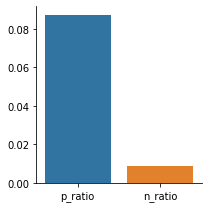

In [66]:
sns.catplot(data=vibes,kind="bar",height=3)

- The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. 
- https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
- Overall vibe is postive

## 5. Sentiment Analysis-Part 4.  Neighbourhood

In [67]:
gb = rm.groupby('neighbourhood_cleansed').senti_score.mean()

In [68]:
gb_frame = gb.to_frame().reset_index().sort_values('senti_score', ascending=False)
gb_frame.head()

neighbourhood_cleansed  senti_score
26                Tribeca     0.426927
6      Financial District     0.424213
0       Battery Park City     0.422929
23                   SoHo     0.420894
24        Stuyvesant Town     0.417126

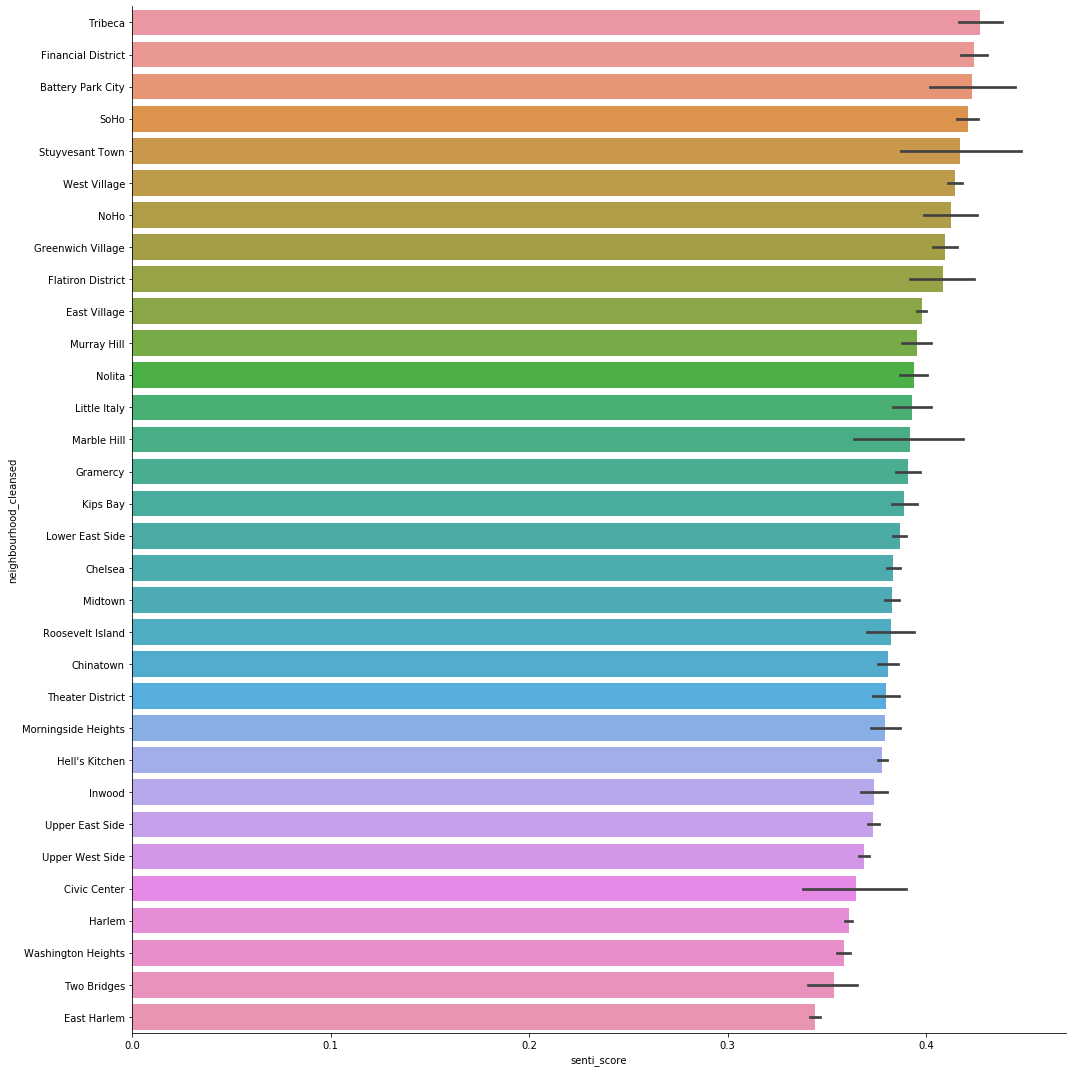

In [69]:
sns.catplot(x='senti_score', y='neighbourhood_cleansed',\
            data=rm, kind='bar', aspect=1, height=15, order=gb_frame.neighbourhood_cleansed.values)

neighbourhood_cleansed  senti_score
26                Tribeca     0.426927
6      Financial District     0.424213
0       Battery Park City     0.422929
23                   SoHo     0.420894
24        Stuyvesant Town     0.417126

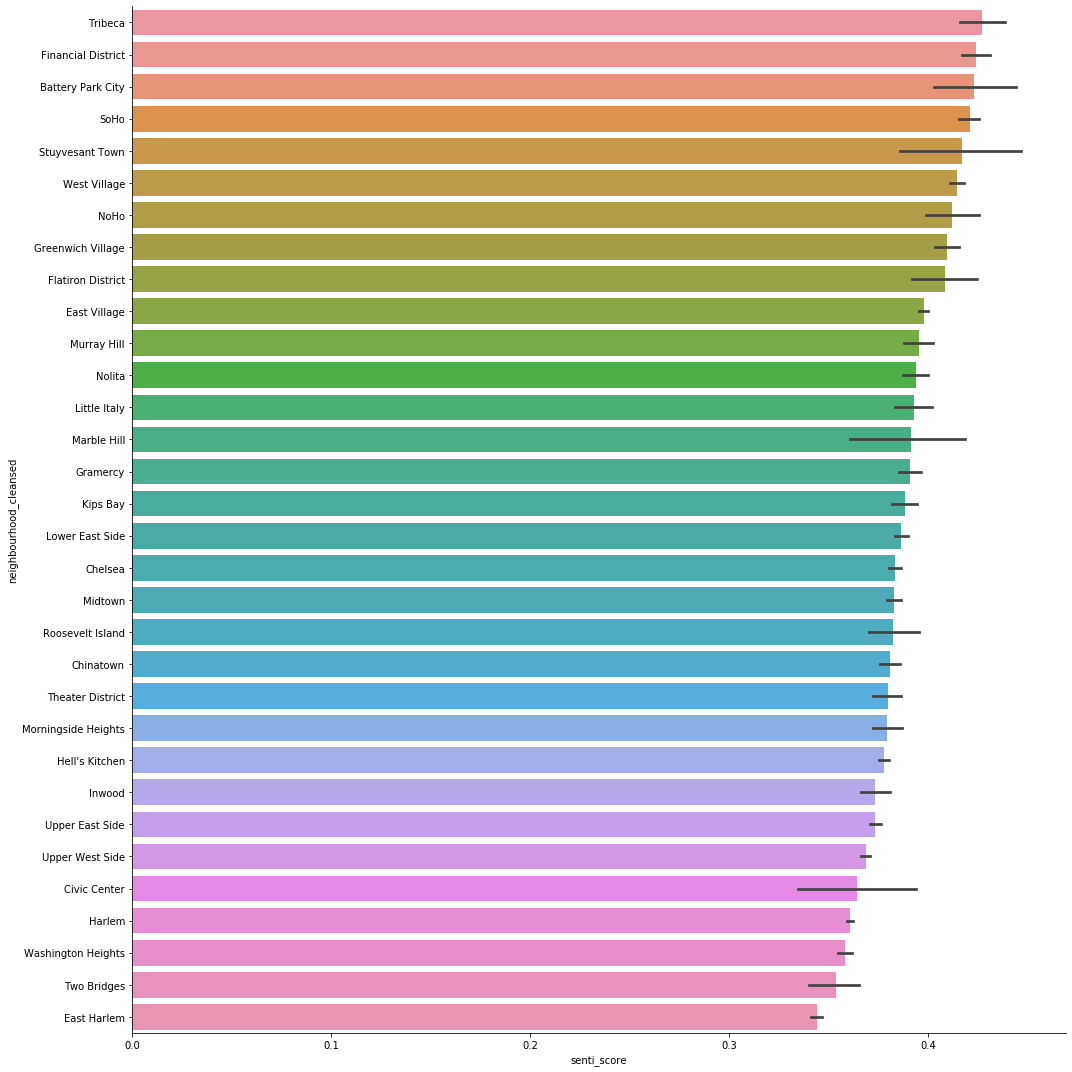

In [70]:
gb = rm.groupby('neighbourhood_cleansed').senti_score.mean()
gb_frame = gb.to_frame().reset_index().sort_values('senti_score', ascending=False)
gb_frame.head()
sns.catplot(x='senti_score', y='neighbourhood_cleansed',\
            data=rm, kind='bar', aspect=1, height=15, order=gb_frame.neighbourhood_cleansed.values)

In [71]:
import plotly.express as px
import json
#import geojson
with open('neighbourhoods.geojson') as f:
    gj = json.load(f)

In [72]:
fig = px.choropleth_mapbox(gb_frame, geojson=gj, color="senti_score",
                           locations="neighbourhood_cleansed", featureidkey="properties.neighbourhood",
                           center={"lat": 40.78, "lon": -73.97},
                           mapbox_style="carto-positron", zoom=10, hover_name='neighbourhood_cleansed',
                           hover_data={'neighbourhood_cleansed': False, 'senti_score':True})
fig.show()

## 6. Sentiment Analysis - Part 6. Property Type

In [73]:
pt = rm.groupby('property_type').senti_score.mean()

In [74]:
pt_frame = pt.to_frame().reset_index().sort_values('senti_score', ascending=False)
pt_frame.head()

property_type  senti_score
47    Shared room in tent     0.562500
45  Shared room in island     0.487004
29     Room in aparthotel     0.462939
49             Tiny house     0.456067
5         Entire home/apt     0.454846

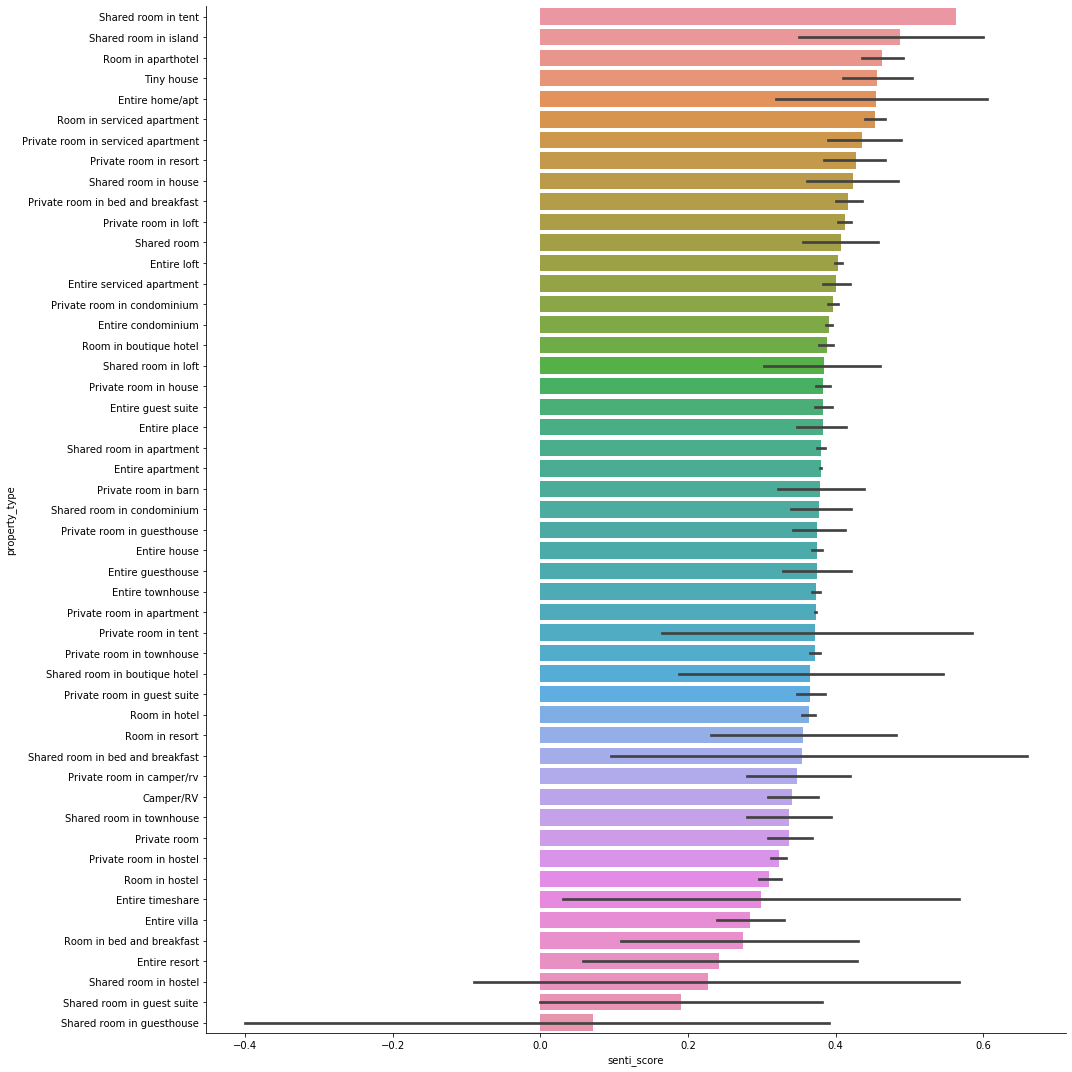

In [75]:
sns.catplot(x='senti_score', y='property_type',\
            data=rm, kind='bar', aspect=1, height=15, order=pt_frame.property_type.values)

# Finding 2: Price Prediction

## 1. Price Prediction- Data Exploratory

### A brief summary ... 

We are going to explore the pattern of house prices based on house features and  outer data sources such as the location of NYC transit and popular attractions to predict price by leveraging regression models.

### a. Target Variable - Price

In [76]:
listing_Mah.price.describe()

count    19741.000000
mean       194.142496
std        432.154775
min          0.000000
25%         81.000000
50%        128.000000
75%        200.000000
max      10000.000000
Name: price, dtype: float64

- Majority of price falls between 0 to 200, however the maximum price is $10000

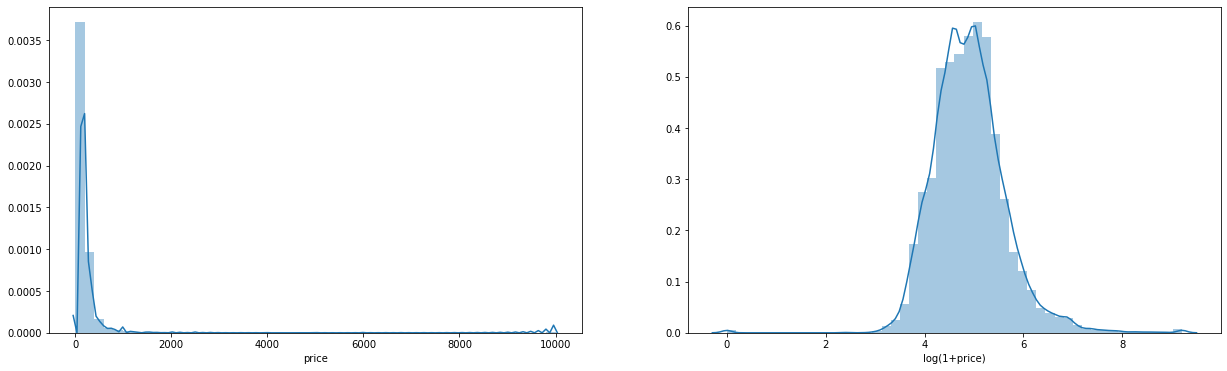

In [77]:
fig, axes = plt.subplots(1,2, figsize=(21,6))
colors = ["#FF5A5F","#00A699","#767676"]
sns.set_palette(sns.color_palette(colors))
sns.distplot(listing_Mah['price'], ax=axes[0])

sns.distplot(np.log1p(listing_Mah['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)');


In [78]:
listing_Mah["log_price"]=np.log1p(listing_Mah['price'])

In this part, we decide to use log_price as our dependent variable in the ML process since the distribution of price is extreme skewness.

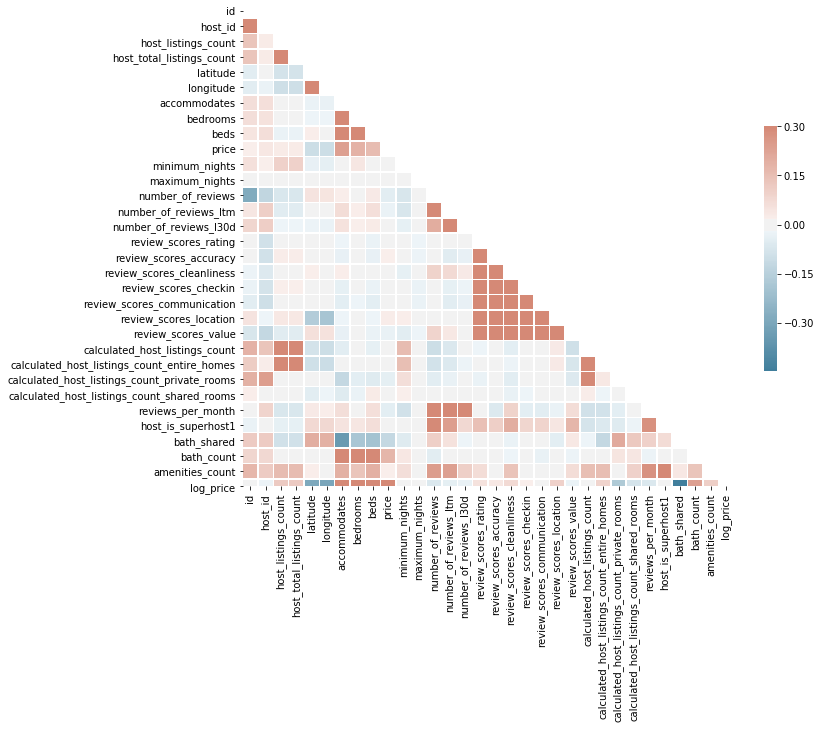

In [79]:
cor=listing_Mah.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### b. Labeling Neighbourhood_cleansed

Using List_of_Neighborhood.csv to assign the Neighborhood with area label.
(Downtown, Islands,Midtown, Midtown and Downtown,Uptown)

Data Source:https://en.wikipedia.org/wiki/List_of_Manhattan_neighborhoods

This is a list of neighborhoods in the New York City borough of Manhattan arranged geographically from the north of the island to the south.

In [80]:
NYC_neigh_list=pd.read_csv("List_of_Neighborhood.csv",index_col="Name of the Neighborhood")

In [81]:
NYC_neigh_list.head()

List of Manhattan neighborhoods  \
Name of the Neighborhood                                   
Upper Manhattan                                   Uptown   
Marble Hill                                       Uptown   
Inwood                                            Uptown   
Fort George                                       Uptown   
Washington Heights                                Uptown   

                                                                 Definition  
Name of the Neighborhood                                                     
Upper Manhattan                                               above 95th St  
Marble Hill                              physically located on the mainland  
Inwood                                                     above Dyckman St  
Fort George               Between Nagel Ave, Dyckman St and 192nd, inclu...  
Washington Heights                            W155 (once 125) to Dyckman St

In [82]:
NYC_neigh_list=NYC_neigh_list.iloc[:,0:1]
NYC_neigh_dict=NYC_neigh_list.T.to_dict("list")

In [83]:
def categorized_neigh(neighbourhood,NYC_neigh_dict):
    if neighbourhood in NYC_neigh_dict:
        return NYC_neigh_dict[neighbourhood][0]

In [84]:
listing_Mah["List_of_Neighborhood"]=listing_Mah.neighbourhood_cleansed\
.apply(lambda x:categorized_neigh(x,NYC_neigh_dict))

In [85]:
listing_Mah.List_of_Neighborhood.isna().sum()

0

In [86]:
listing_Mah.drop(columns="neighbourhood_cleansed",inplace=True)

- Price distribution based on List_of_Neighborhood indicates that the price range among areas are wide and Midtown has highest average price.

In [87]:
listing_Mah.groupby("List_of_Neighborhood")\
.agg({"price":["mean",lambda x:x.max()-x.min()],"id":"count"})\
.rename(columns={"<lambda_0>":"Price range","mean":"Avg Price","count":"Number of listing"})

price                            id
                       Avg Price Price range Number of listing
List_of_Neighborhood                                          
Downtown              219.948064     10000.0              5443
Islands                99.540000      1371.0                91
Midtown               245.244506     10000.0              4150
Midtown and Downtown  215.074284      6790.0              1865
Uptown                147.394204     10000.0              8192

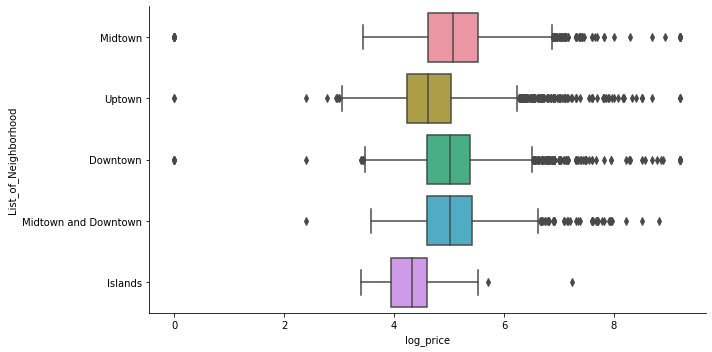

In [88]:
sns.catplot(x="log_price",y="List_of_Neighborhood",data=listing_Mah,kind='box',aspect=2)

### c. Property Type & Room Type

- Majority of listing types are apartment

In [89]:
listing_Mah.groupby("property_type_cat").id.count()

property_type_cat
apartment    17590
hostel         102
hotel          755
house         1281
other           13
Name: id, dtype: int64

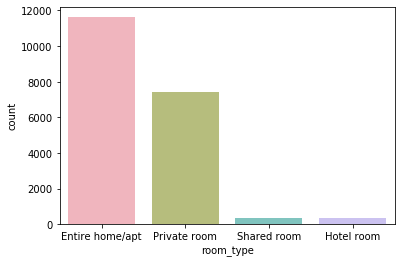

In [90]:
listing_Mah.groupby("room_type").id.count()
sns.countplot(x='room_type', data=listing_Mah,alpha=0.7)
plt.show;

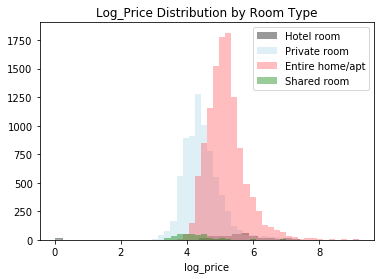

In [91]:
sns.distplot(listing_Mah[listing_Mah['room_type']=='Hotel room'].log_price, kde=False,label='Hotel room',color='black')
sns.distplot(listing_Mah[listing_Mah['room_type']=='Private room'].log_price, kde=False,label='Private room',color='lightblue')
sns.distplot(listing_Mah[listing_Mah['room_type']=='Entire home/apt'].log_price, kde=False,label='Entire home/apt')
sns.distplot(listing_Mah[listing_Mah['room_type']=='Shared room'].log_price, kde=False,label='Shared room',color='green')

plt.title('Log_Price Distribution by Room Type')
plt.xlabel('log_price')
plt.legend()
plt.grid(False);

## 2. Price Prediction- Adding New Variables 

Using NYC_Subway.csv to obtain the location info of subway stations in NYC so that we can utilize it to calculate the distance and the number of stations close to listing in 500m.

Data Source: https://data.ny.gov/Transportation/NYC-Transit-Subway-Entrance-And-Exit-Data/i9wp-a4ja

In [92]:
NYC_Sub=pd.read_csv("NYC_Subway.csv")

In [93]:
NYC_Sub.head()

Division      Line Station Name  Station Latitude  Station Longitude Route1  \
0      BMT  4 Avenue      25th St         40.660397         -73.998091      R   
1      BMT  4 Avenue      25th St         40.660397         -73.998091      R   
2      BMT  4 Avenue      36th St         40.655144         -74.003549      N   
3      BMT  4 Avenue      36th St         40.655144         -74.003549      N   
4      BMT  4 Avenue      36th St         40.655144         -74.003549      N   

  Route2 Route3 Route4 Route5  ...    ADA ADA Notes  Free Crossover  \
0    NaN    NaN    NaN    NaN  ...  False       NaN           False   
1    NaN    NaN    NaN    NaN  ...  False       NaN           False   
2      R    NaN    NaN    NaN  ...  False       NaN            True   
3      R    NaN    NaN    NaN  ...  False       NaN            True   
4      R    NaN    NaN    NaN  ...  False       NaN            True   

   North South Street  East West Street  Corner Entrance Latitude  \
0             4th Ave           25th St      SW         40.660489   
1             4th Ave           25th St      SE         40.660323   
2             4th Ave           36th St      NW         40.654676   
3             4th Ave           36th St      NE         40.654365   
4             4th Ave           36th St      NW         40.654490   

  Entrance Longitude         Station Location        Entrance Location  
0         -73.998220  (40.660397, -73.998091)   (40.660489, -73.99822)  
1         -73.997952  (40.660397, -73.998091)  (40.660323, -73.997952)  
2         -74.004306  (40.655144, -74.003549)  (40.654676, -74.004306)  
3         -74.004113  (40.655144, -74.003549)  (40.654365, -74.004113)  
4         -74.004499  (40.655144, -74.003549)   (40.65449, -74.004499)  

[5 rows x 32 columns]

In [94]:
NYC_Sub=NYC_Sub.iloc[:,:5]

In [95]:
len(NYC_Sub)
NYC_Sub["Station Name"].nunique()

1868

356

In [96]:
NYC_Sub=NYC_Sub.drop_duplicates(subset ="Station Name")

In [97]:
#Define the Function to Calculate the Distance m
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine
    diff_long = lon2 - lon1 
    diff_lat = lat2 - lat1 
    a = sin(diff_lat/2)**2 + cos(lat1) * cos(lat2) * sin(diff_long/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 #
    return c * r * 1000


In [98]:
def station_count_500m(long,lat,station_df):
    count=0
    for index_i, row_i in station_df.iterrows():
        if haversine(long, lat, row_i["Station Longitude"], row_i["Station Latitude"])<=500:
            count+=1
    return count

In [99]:
#listing_Mah=pd.read_csv("listing_Mah.csv")

In [100]:
%%time
listing_Mah["station_count_500m"]=listing_Mah\
.apply(lambda x: station_count_500m(x.longitude,x.latitude,NYC_Sub),axis=1)


CPU times: user 14min 51s, sys: 2.28 s, total: 14min 54s
Wall time: 15min 4s


In [101]:
#listing_Mah.to_csv("listing_Mah.csv")

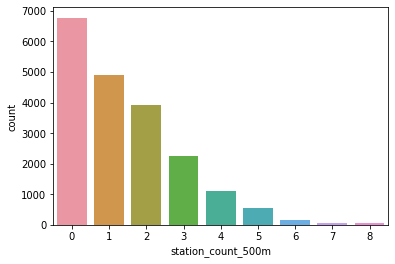

In [102]:
sns.countplot(data=listing_Mah, x="station_count_500m");

- Higher number of stations nearby the listing tends to have higher price

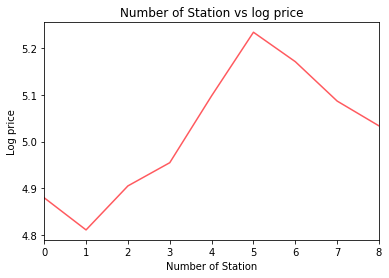

In [103]:
listing_Mah.groupby("station_count_500m").log_price.mean().plot()
plt.xlabel("Number of Station")
plt.ylabel("Log price")
plt.title("Number of Station vs log price");

Using NYC_Top20.csv to count the nearby attractions

Data Source: https://www.timeout.com/newyork/attractions/top-attractions-in-manhattan

In [104]:
nyc_top20=pd.read_csv("NYC_Top20.csv")

In [105]:
nyc_top20.head()

Attraction  Latitude  Longitude
0                    Central Park  40.78509 -73.968285
1           Empire State Building  40.74844 -73.985664
2           The Statue Of Liberty  40.74882 -73.985428
3              World Trade Center  40.71274 -74.013382
4  The Metropolitan Museum Of Art  40.77897 -73.962311

In [106]:
def landmark_1k(long,lat,df):
    count=0
    for index_i, row_i in df.iterrows():
        if haversine(long, lat, row_i["Longitude"], row_i["Latitude"])<=1000:
            count+=1
    return count

In [107]:
%%time
listing_Mah["nyc_attraction_1000m"]=listing_Mah\
.apply(lambda x: landmark_1k(x.longitude,x.latitude,nyc_top20),axis=1)

CPU times: user 52.1 s, sys: 104 ms, total: 52.2 s
Wall time: 52.9 s


- The highest price of the listings are close to lots popular attractions

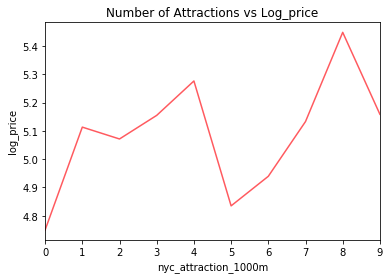

In [108]:
listing_Mah.groupby("nyc_attraction_1000m").log_price.mean().plot()
plt.ylabel("log_price")
plt.xlabel("nyc_attraction_1000m")
plt.title("Number of Attractions vs Log_price");

- Top 10 high correlated variables with price including new variables ( station_count_500m & nyc_attraction_1000m ) 

In [109]:
cor=listing_Mah.corr()
cor[cor<1].log_price.sort_values().nlargest(10)

log_price                    0.577437
accommodates                 0.233563
bedrooms                     0.185421
bath_count                   0.176843
beds                         0.157397
nyc_attraction_1000m         0.066058
station_count_500m           0.059439
host_id                      0.039696
host_total_listings_count    0.029437
host_listings_count          0.029437
Name: price, dtype: float64

- Based on the correlation table above, it validates our ideas that subway station and attraction highly correlate to the listing price so we decide to include them in our machine learning process

## 3. Price Prediction-Get Dummies of categorical variables

In [110]:
listing_Mah_dum=pd.get_dummies(data=listing_Mah,columns=["room_type","List_of_Neighborhood","property_type_cat"])

In [111]:
listing_Mah_dum.head()

id  host_id  host_listings_count  host_total_listings_count  latitude  \
0  2595     2845                  6.0                        6.0  40.75362   
4  5178     8967                  1.0                        1.0  40.76489   
5  5203     7490                  1.0                        1.0  40.80178   
6  5552     8380                  1.0                        1.0  40.73552   
8  6021    11528                  2.0                        2.0  40.79826   

   longitude  accommodates  bedrooms  beds  price  ...  \
0  -73.98377             2       1.0   1.0  175.0  ...   
4  -73.98493             2       1.0   1.0   73.0  ...   
5  -73.96723             1       1.0   1.0   75.0  ...   
6  -74.01042             2       1.0   1.0  160.0  ...   
8  -73.96113             1       1.0   1.0   85.0  ...   

   List_of_Neighborhood_Downtown  List_of_Neighborhood_Islands  \
0                              0                             0   
4                              0                             0   
5                              0                             0   
6                              1                             0   
8                              0                             0   

   List_of_Neighborhood_Midtown  List_of_Neighborhood_Midtown and Downtown  \
0                             1                                          0   
4                             1                                          0   
5                             0                                          0   
6                             0                                          0   
8                             0                                          0   

   List_of_Neighborhood_Uptown  property_type_cat_apartment  \
0                            0                            1   
4                            0                            1   
5                            1                            1   
6                            0                            1   
8                            1                            1   

   property_type_cat_hostel  property_type_cat_hotel  property_type_cat_house  \
0                         0                        0                        0   
4                         0                        0                        0   
5                         0                        0                        0   
6                         0                        0                        0   
8                         0                        0                        0   

   property_type_cat_other  
0                        0  
4                        0  
5                        0  
6                        0  
8                        0  

[5 rows x 48 columns]

## 4. Price Prediction- Machine Learning

In [112]:
import sklearn as sk
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [113]:
X=listing_Mah_dum[[col for col in listing_Mah_dum.columns if col not in ['id',"host_id",'price','log_price']]]
y=listing_Mah_dum.log_price

### a. Feature Scaling

- We scale the x dataset before training the model since we are going to compare different regressors later and some of them are sensitive to the distance.

In [114]:
columns=X.columns.tolist()
scaler=sk.preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=columns)
X.head()

host_listings_count  host_total_listings_count  latitude  longitude  \
0            -0.141675                  -0.141675 -0.308178  -0.421759   
1            -0.170329                  -0.170329 -0.013166  -0.474510   
2            -0.170329                  -0.170329  0.952495   0.330392   
3            -0.170329                  -0.170329 -0.781977  -1.633658   
4            -0.164598                  -0.164598  0.860353   0.607787   

   accommodates  bedrooms      beds  minimum_nights  maximum_nights  \
0     -0.448822 -0.389029 -0.478616       -0.283534       -0.007086   
1     -0.448822 -0.389029 -0.478616       -0.318957       -0.007158   
2     -1.054028 -0.389029 -0.478616       -0.318957       -0.007158   
3     -0.448822 -0.389029 -0.478616       -0.283534       -0.007158   
4     -1.054028 -0.389029 -0.478616       -0.318957       -0.007111   

   number_of_reviews  ...  List_of_Neighborhood_Downtown  \
0           0.673065  ...                      -0.616995   
1          10.572714  ...                      -0.616995   
2           2.303596  ...                      -0.616995   
3           1.092345  ...                       1.620759   
4           2.420062  ...                      -0.616995   

   List_of_Neighborhood_Islands  List_of_Neighborhood_Midtown  \
0                     -0.068052                      1.938264   
1                     -0.068052                      1.938264   
2                     -0.068052                     -0.515926   
3                     -0.068052                     -0.515926   
4                     -0.068052                     -0.515926   

   List_of_Neighborhood_Midtown and Downtown  List_of_Neighborhood_Uptown  \
0                                  -0.323001                    -0.842215   
1                                  -0.323001                    -0.842215   
2                                  -0.323001                     1.187346   
3                                  -0.323001                    -0.842215   
4                                  -0.323001                     1.187346   

   property_type_cat_apartment  property_type_cat_hostel  \
0                     0.349693                 -0.072068   
1                     0.349693                 -0.072068   
2                     0.349693                 -0.072068   
3                     0.349693                 -0.072068   
4                     0.349693                 -0.072068   

   property_type_cat_hotel  property_type_cat_house  property_type_cat_other  
0                -0.199415                -0.263426                 -0.02567  
1                -0.199415                -0.263426                 -0.02567  
2                -0.199415                -0.263426                 -0.02567  
3                -0.199415                -0.263426                 -0.02567  
4                -0.199415                -0.263426                 -0.02567  

[5 rows x 44 columns]

### b. Split Data into Train and Test set

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(f'The shape of Xtrain:{X_train.shape}')
print(f'The shape of Xtest:{X_test.shape}')
print(f'The shape of ytrain:{y_train.shape}')
print(f'The shape of ytest:{y_test.shape}')

The shape of Xtrain:(14805, 44)
The shape of Xtest:(4936, 44)
The shape of ytrain:(14805,)
The shape of ytest:(4936,)


### c. Grid Search - Finding the parameters for RandomForestRegressor 

In [116]:
%%time
n_estimators=[9,10,11,12]
max_depth=[i for i in range(10,16,2)]
max_features=[i for i in range(10,16,1)]
#min_samples_leaf=2
#min_samples_split=2
parameters = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'max_features':max_features
    #,'min_samples_leaf':min_samples_leaf,
    #'min_samples_split':min_samples_split
}
rf = RandomForestRegressor(random_state=0)
GS=GridSearchCV(rf,parameters,cv=3)
GS.fit(X_train,y_train)

CPU times: user 42.1 s, sys: 338 ms, total: 42.4 s
Wall time: 42.9 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 12, 14],
       

In [117]:
GS.best_params_

{'max_depth': 14, 'max_features': 10, 'n_estimators': 12}

In [118]:
nfolds=3
kf = KFold(n_splits=nfolds,random_state=0,shuffle=True)

In [119]:
def mse_score(model):
    return cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=kf)
def mae_score(model):
    return cross_val_score(model,X,y,scoring='neg_mean_absolute_error',cv=kf)
def cv_score(model):
    return cross_val_score(model, X, y, cv=kf)

### d. RandomForestRegressor

In [120]:
rf_model=RandomForestRegressor(random_state=0,n_estimators=12,max_depth=14,max_features=14,min_samples_leaf=2,min_samples_split=2)

In [121]:
rf_model = rf_model.fit(X_train,y_train)
rf_predict_ytrain = rf_model.predict(X_train)
rf_predict_ytest = rf_model.predict(X_test)

In [122]:
rf_result=pd.DataFrame({'model':['RandomForestRegressor'],
                'Cross Validation Score:':cv_score(rf_model).mean(),
                'MAE Score:':-mae_score(rf_model).mean(),
                "MSE Score:":-mse_score(rf_model).mean(),
                'R squared on Test:':r2_score(y_test,rf_predict_ytest),
                'R squared on train:':r2_score(y_train,rf_predict_ytrain)})
rf_result

model  Cross Validation Score:  MAE Score:  MSE Score:  \
0  RandomForestRegressor                 0.585715    0.318449    0.223593   

   R squared on Test:  R squared on train:  
0            0.572439             0.767979

- Inverse the log price to price to make mean absolute error interpretable.

In [123]:
inverse_test=np.expm1(y_test)
inverse_pred=np.expm1(rf_predict_ytest)

In [124]:
#error
inverse_mae=mean_absolute_error(inverse_test,inverse_pred)
inverse_rmse=mean_squared_error(inverse_test,inverse_pred)**0.5
print("Mean Absolute Error in USD is $"+ str(inverse_mae)[:6])
print("Root Mean Squared Error in USD is $"+ str(inverse_rmse)[:6])

Mean Absolute Error in USD is $79.969
Root Mean Squared Error in USD is $360.39


- Majority of data are near the regression line, however, when log_price goes higher the deviation becomes larger.

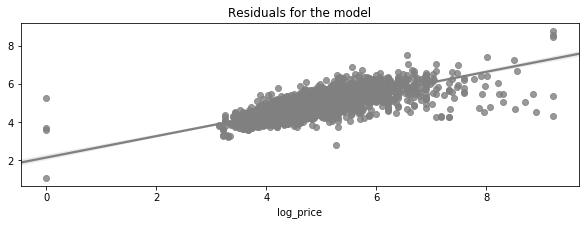

In [125]:
fig = plt.figure(figsize=(10,3))

sns.regplot((y_test),(rf_predict_ytest),color="grey")
plt.title("Residuals for the model");

### e. Feature Importance

In [126]:
importance = rf_model.feature_importances_
columns = X_train.columns
d = pd.Series(data=importance,index=columns)

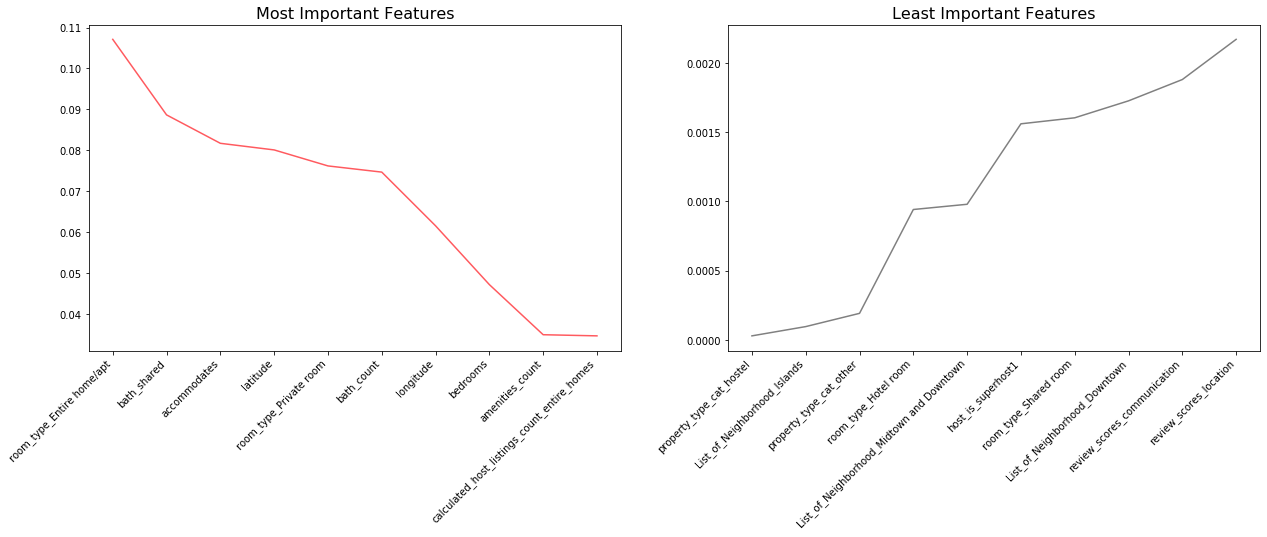

In [127]:
fig = plt.figure(figsize=(21,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Most Important Features',size=16)

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Least Important Features',size=16)

plt.sca(ax1)
plt.xticks(rotation=45, ha='right')
ax1.plot(d.nlargest(10))

plt.sca(ax2)
plt.xticks(rotation=45, ha='right')
ax2.plot(d.nsmallest(10),color="grey");

### f. Compare our model(RandomForestRegressor) with others

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn import linear_model
import sklearn as sk
from sklearn.model_selection import KFold

In [129]:
regs = [LinearRegression(), ElasticNet(), DecisionTreeRegressor(), GradientBoostingRegressor(), MLPRegressor()\
, SVR(),linear_model.Lasso()] 
regs_name = ["LinearRegression", "ElasticNet", "DecisionTreeRegressor", "GradientBoostingRegressor", "MLPRegressor",
"SVR","Lasso"] 

In [130]:
%%time
regression_dict={"Model":["RandomForestRegressor"],
                 "MAE":[-mae_score(rf_model).mean()]}

for reg,name in zip(regs,regs_name):
    mae = -sk.model_selection.cross_val_score(reg,X,y,\
             cv=kf,scoring='neg_mean_absolute_error').mean()
    regression_dict["Model"].append(name)
    regression_dict["MAE"].append(mae)
    
regression_result=pd.DataFrame(regression_dict).sort_values("MAE")

CPU times: user 1min 39s, sys: 4.1 s, total: 1min 43s
Wall time: 1min 22s


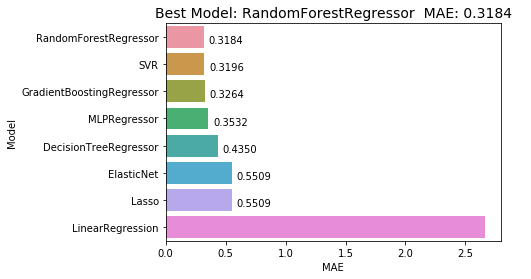

In [131]:
ax=sns.barplot(x="MAE",y="Model",data=regression_result)
for p in ax.patches:
    ax.annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 1),
                xytext=(5, 10), textcoords='offset points')
plt.title("Best Model: "+regression_result.Model[0]+" "+" MAE: "+str(round(regression_result.MAE[0],4)),size=14)
plt.show;

Listing price is extreme right skewness so we determine to use log_price as our predicted variable in Machine Learning process. According to outcome of feature importance, the most important variable is room_type_Entire home/Apt, whereas property_type_cat_hostel is the least. To find the best regressor model, we introduce and compare different regression methods. Among all regressors, the model of RandomForestRegressor performs the best with MAE=0.318, which is tuned by Grid Search in our main workflow.

### Managerial insights of Finding 2:

Our regression model can sucessfully support the business by predicting the benchmark of listing price, and futher being used as the prototype of pricing recommendation system for new hosts. Besides, the result of feature importance indicates the factors that model can be improved in the future reseach and development. 
We believe our accomplishment can provide business insights on Airbnb operation in real business scene.

# Finding 3: Super Host

## 2. Super Host- Data Exploratory

In [132]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [133]:
#df2 = pd.get_dummies(df2, columns = ["host_response_time"])

In [1]:
df2.head()

NameError: name 'df2' is not defined

## a. Overview of Super Host in Manhattan

1. Key Metrics Overview

In [136]:
# Significant difference in price, review scores, review volumes, & response rate
df2.groupby("host_is_superhost", axis=0)\
[["price", "review_scores_rating",\
 "amenities_count", "number_of_reviews", "number_of_reviews_ltm", \
  "host_response_rate"]].mean()

price  review_scores_rating  amenities_count  \
host_is_superhost                                                 
RegularHost       196.46                 93.35            17.60   
SuperHost         180.00                 96.81            24.95   

                   number_of_reviews  number_of_reviews_ltm  \
host_is_superhost                                             
RegularHost                    13.99                   2.45   
SuperHost                      50.38                   9.10   

                   host_response_rate  
host_is_superhost                      
RegularHost                      0.35  
SuperHost                        0.69

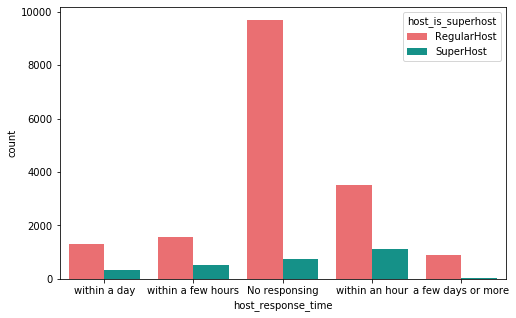

In [142]:
plt.subplots(figsize=(8, 5))
sns.countplot("host_response_time",hue="host_is_superhost",data=df2)

2. Proportion: Superhost takes up 14% of the total hosts in Manhattan

In [143]:
len(df2[df2.host_is_superhost == 'SuperHost'])
len(df2[df2.host_is_superhost == 'RegularHost'])
df2.host_is_superhost1.mean() * 100

2777

16964

14.067169849551695

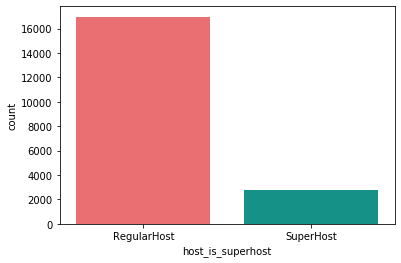

In [144]:
sns.countplot(x = 'host_is_superhost', data = df2)

## b. Ratings Discovery

1. Overall Rating: review_scores_rating=96 is a good threshold to seperate Super Host from Regular Host

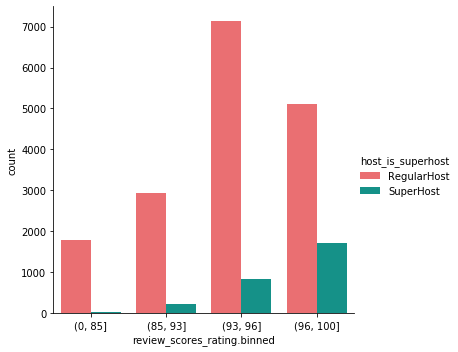

In [145]:
df2['review_scores_rating.binned'] = pd.cut(df2['review_scores_rating'], bins=[0,85,93,96,100])
sns.catplot(x='review_scores_rating.binned',hue='host_is_superhost',\
            data=df2, kind='count', aspect = 1)

2. Quality Rating: what does guests value most when rating?

In [146]:
# Superhost has a high correlation with number of amenities, as the top 1
# Then it's cleanliness, value, communication, and checkin
# Those areas should be addressed when regular hosts wants to improve their ratings
cor = df2.corr()
corsh = cor.host_is_superhost1.sort_values(ascending = False)[["amenities_count", "review_scores_cleanliness"\
                                                     , "review_scores_value", "review_scores_communication",\
                                                      "review_scores_checkin"]]
corsh

amenities_count               0.30
review_scores_cleanliness     0.20
review_scores_value           0.18
review_scores_communication   0.09
review_scores_checkin         0.09
Name: host_is_superhost1, dtype: float64

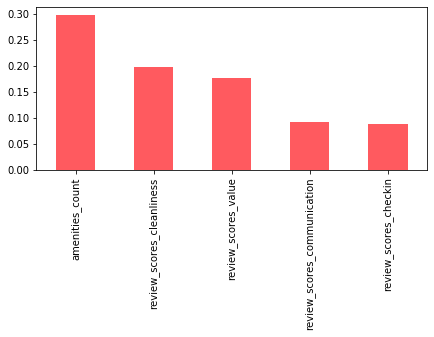

In [147]:
fig = plt.figure(figsize=(7,3))
corsh.plot(kind ="bar", rot = 90)

3. Occupancy Rating: differences in number of reviews of last 12 months

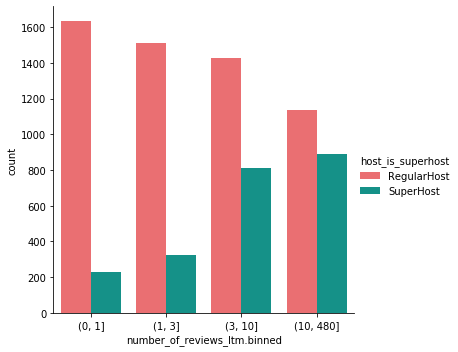

In [148]:
# superhost has an average # of reviews of 9.1 while regular hosts only have 2.45 reviews
df2['number_of_reviews_ltm.binned'] = pd.cut(df2['number_of_reviews_ltm'], bins=[0,1,3,10,480])
sns.catplot(x='number_of_reviews_ltm.binned',kind = "count",hue='host_is_superhost',\
            data=df2, aspect = 1);

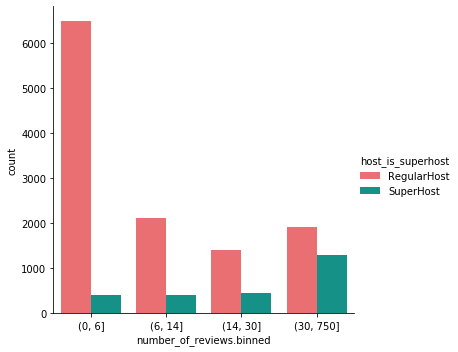

In [149]:
# the average total number of reviews of superhost is 50 while regular hosts concentrated below 14
df2['number_of_reviews.binned'] = pd.cut(df2['number_of_reviews'], bins=[0,6,14,30,750])
sns.catplot(x='number_of_reviews.binned',kind = "count",hue='host_is_superhost',\
            data=df2, aspect = 1);

4. Service Rate: Host response rate comparison

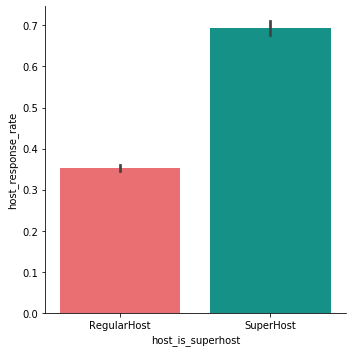

In [150]:
# The response rate of superhost is twice as much as the regular host
sns.catplot(x = "host_is_superhost", y = "host_response_rate", kind = "bar", data = df2, aspect = 1)

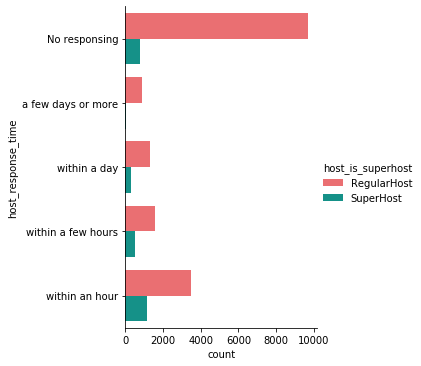

In [155]:
sns.catplot(y = "host_response_time", kind = "count", hue = "host_is_superhost", data = df2, \
            order = ["No responsing", "a few days or more", "within a day", "within a few hours", \
                    "within an hour"])

## c. Price

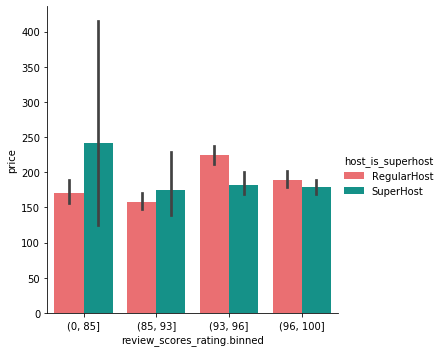

In [156]:
# super host suprisinglly charges less than regular host when their review scores are higher
sns.catplot(x = "review_scores_rating.binned", y = "price", hue = "host_is_superhost", kind = "bar", data = df2)

## d. Map

In [157]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [158]:
sh = df2[df2.host_is_superhost=='SuperHost']

px.set_mapbox_access_token ='pk.eyJ1IjoiYWxhbnR6dGFuIiwiYSI6ImNqa2VqeHFnejB1dTEzcHBxczBhaGZhZ2gifQ.moVxmxTkE53tZDfBFr3uYA'
fig2 = px.scatter_mapbox(data_frame=sh, 
                        lat="latitude", 
                        lon="longitude",
                        color="host_is_superhost",
                        color_discrete_sequence=['#FF5A5F'],
                        opacity=0.7,
                        size_max=10)
fig2.update_layout(mapbox_style="carto-positron",\
                  mapbox_zoom=11, mapbox_center = {"lat": 40.75, "lon": -73.98})

## Conclusion:

1. To become a superhost, hosts can further work on amenities, cleanliness, value, communication, and check-in, one by one.
2. Superhost doesn't charge more because of their high review rating. To maximize the profit, we could increase the price to match up with the quality of the house and service hosts provided.